In [3]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import os
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import NFD, StripAccents, Sequence
import torch
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import ByteLevel
from transformers import AutoTokenizer, AutoModel

In [5]:
# !hf download sentence-transformers/LaBSE

In [2]:
model_path = "/tmp/hf/hub/models--sentence-transformers--LaBSE/snapshots/836121a0533e5664b21c7aacc5d22951f2b8b25b"
model = SentenceTransformer(model_path)

In [3]:
model_path = "/tmp/hf/hub/models--sentence-transformers--LaBSE/snapshots/836121a0533e5664b21c7aacc5d22951f2b8b25b"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

print(f"Размер словаря: {len(tokenizer)}")

test_words = ['ꜣ', 'ꜥ', 'ḥ', 'ḫ', 'ẖ', 'ḏ', 'ṯ', 'š', 'ı']
print("\n=== Проверка специальных символов ===")
for char in test_words:
    tokens = tokenizer.tokenize(char)
    token_ids = tokenizer.encode(char, add_special_tokens=False)
    print(f"{char} → {tokens} (IDs: {token_ids})")

test_sentences = [
    'jrj-jḫ,t-nsw,t špss',
    'ḫtmw-bj,tj smr-wꜥ,tj',
    'mw.t zꜣ.t jtj'
]

print("\n=== Токенизация предложений ===")
for sent in test_sentences:
    tokens = tokenizer.tokenize(sent)
    print(f"\n{sent}")
    print(f"  Токены: {tokens}")
    print(f"  Количество: {len(tokens)}")

test_words_with_endings = ['mw.t', 'zꜣ.t', 'jr.t', 'ẖr.t']
print("\n=== Проверка окончаний .t ===")
for word in test_words_with_endings:
    tokens = tokenizer.tokenize(word)
    print(f"{word:10s} → {tokens}")

Размер словаря: 501153

=== Проверка специальных символов ===
ꜣ → ['[UNK]'] (IDs: [100])
ꜥ → ['[UNK]'] (IDs: [100])
ḥ → ['ḥ'] (IDs: [2770])
ḫ → ['[UNK]'] (IDs: [100])
ẖ → ['ẖ'] (IDs: [2789])
ḏ → ['ḏ'] (IDs: [2764])
ṯ → ['[UNK]'] (IDs: [100])
š → ['š'] (IDs: [385])
ı → ['ı'] (IDs: [342])

=== Токенизация предложений ===

jrj-jḫ,t-nsw,t špss
  Токены: ['jr', '##j', '-', '[UNK]', ',', 't', '-', 'ns', '##w', ',', 't', 'š', '##ps', '##s']
  Количество: 14

ḫtmw-bj,tj smr-wꜥ,tj
  Токены: ['[UNK]', '-', 'bj', ',', 'tj', 'sm', '##r', '-', '[UNK]', ',', 'tj']
  Количество: 11

mw.t zꜣ.t jtj
  Токены: ['mw', '.', 't', '[UNK]', '.', 't', 'jt', '##j']
  Количество: 8

=== Проверка окончаний .t ===
mw.t       → ['mw', '.', 't']
zꜣ.t       → ['[UNK]', '.', 't']
jr.t       → ['jr', '.', 't']
ẖr.t       → ['ẖ', '##r', '.', 't']


In [4]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors
from tokenizers.normalizers import NFKC, Sequence
import re

def train_egyptian_wordpiece(vocab_size=1000, corpus_path="altes_reich_lemmas_NORMALIZED.txt"):
    """
    Создает и обучает WordPiece-токенизатор, совместимый с LaBSE.
    """
    tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

    tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()

    trainer = trainers.WordPieceTrainer(
        vocab_size=vocab_size,  
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
        continuing_subword_prefix="##", 
        show_progress=True,
        min_frequency=2  
    )

    tokenizer.train([corpus_path], trainer)


    tokenizer.save("trained_egyptian_wordpiece_tokenizer.json")
    print(f"[✓] WordPiece-токенизатор обучен и сохранен. Словарь: {vocab_size} токенов.")
    
    test_cases = ["nswt", "zꜣ.t", "ḥm-nṯr", "jr.j-jḫ.t", ".t", "##.t"]
    print("\n[Тест разбиения]:")
    for case in test_cases:
        encoded = tokenizer.encode(case)
        print(f"  '{case}' -> {encoded.tokens}")

    return tokenizer

tokenizer = train_egyptian_wordpiece(vocab_size=4000)




[✓] WordPiece-токенизатор обучен и сохранен. Словарь: 4000 токенов.

[Тест разбиения]:
  'nswt' -> ['nswt']
  'zꜣ.t' -> ['zꜣ.t']
  'ḥm-nṯr' -> ['ḥm-nṯr']
  'jr.j-jḫ.t' -> ['jr.j-j', '##ḫ.t']
  '.t' -> ['.', '##t']
  '##.t' -> ['##.t']


In [5]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
import re

def train_egyptian_wordpiece_v2(vocab_size=5000, corpus_path="altes_reich_lemmas_NORMALIZED.txt"):
    """
    Улучшенный токенизатор: сохраняет структуру слов с дефисами и запятыми.
    """

    tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
    
    tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit() # не трогаем дефисы и запятые


    trainer = trainers.WordPieceTrainer(
        vocab_size=vocab_size,
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
        continuing_subword_prefix="##",
        show_progress=True,
        min_frequency=2,
        limit_alphabet=1000 
    )

    print(f"Начинаю обучение на {corpus_path}...")
    tokenizer.train([corpus_path], trainer)
    
    tokenizer.save("trained_egyptian_wordpiece_v2.json")
    
    # --- ТЕСТЫ ---
    print("\n=== ТЕСТ НОВОЙ ТОКЕНИЗАЦИИ ===")
    test_cases = [
        "jrj-jḫ,t-nsw,t", 
        "zꜣ.t", 
        "ḥm-nṯr", 
        "ḫtmw-bj,tj",
        "mw.t"
    ] +  ["nswt", "zꜣ.t", "ḥm-nṯr", "jr.j-jḫ.t", ".t", "##.t"]
    
    
    for case in test_cases:
        encoded = tokenizer.encode(case)
        print(f"'{case:20s}' -> {encoded.tokens}")
        
    return tokenizer

tokenizer_v2 = train_egyptian_wordpiece_v2(vocab_size=6000)

Начинаю обучение на altes_reich_lemmas_NORMALIZED.txt...




=== ТЕСТ НОВОЙ ТОКЕНИЗАЦИИ ===
'jrj-jḫ,t-nsw,t      ' -> ['jr', '##j', '##-j', '##ḫ,t', '##-n', '##sw', '##,t']
'zꜣ.t                ' -> ['zꜣ.t']
'ḥm-nṯr              ' -> ['ḥm-nṯr']
'ḫtmw-bj,tj          ' -> ['ḫtm', '##w', '##-b', '##j', '##,tj']
'mw.t                ' -> ['mw.t']
'nswt                ' -> ['nswt']
'zꜣ.t                ' -> ['zꜣ.t']
'ḥm-nṯr              ' -> ['ḥm-nṯr']
'jr.j-jḫ.t           ' -> ['jr.j-j', '##ḫ.t']
'.t                  ' -> ['.', '##t']
'##.t                ' -> ['##.t']


In [8]:
from transformers import AutoTokenizer, AutoModel
import torch

labse_tokenizer = AutoTokenizer.from_pretrained(model_path)
labse_model = AutoModel.from_pretrained(model_path)

print(f"Исходный размер словаря: {len(labse_tokenizer)}")

from tokenizers import Tokenizer
egyptian_tokenizer = Tokenizer.from_file("trained_egyptian_wordpiece_tokenizer.json")
egyptian_vocab = egyptian_tokenizer.get_vocab()

labse_vocab = set(labse_tokenizer.get_vocab().keys())
new_tokens = [token for token in egyptian_vocab.keys() 
              if token not in labse_vocab 
              and token not in ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]]

print(f"\nНовых токенов для добавления: {len(new_tokens)}")
print(f"Примеры: {new_tokens[:30]}")

num_added = labse_tokenizer.add_tokens(new_tokens)
print(f"\n✓ Добавлено токенов: {num_added}")

labse_model.resize_token_embeddings(len(labse_tokenizer))

print(f"✓ Новый размер словаря: {len(labse_tokenizer)}")
print(f"✓ Новый размер embeddings: {labse_model.get_input_embeddings().weight.shape}")


with torch.no_grad():
    embeddings = labse_model.get_input_embeddings()
    old_embeddings = embeddings.weight.data[:len(labse_tokenizer) - num_added]
    
    # Среднее и стандартное отклонение старых эмбеддингов
    mean = old_embeddings.mean(dim=0)
    std = old_embeddings.std(dim=0)
    
    # Инициализируем новые эмбеддинги из нормального распределения
    for i in range(num_added):
        idx = len(labse_tokenizer) - num_added + i
        embeddings.weight.data[idx] = torch.normal(mean, std)

print("\n=== ТЕСТ РАСШИРЕННОГО ТОКЕНИЗАТОРА ===")
test_words = ['ꜣ', 'ꜥ', 'ḫ', 'ṯ', 'mw.t', 'zꜣ.t', 'jrj-jḫ,t-nsw,t']
for word in test_words:
    tokens = labse_tokenizer.tokenize(word)
    has_unk = '[UNK]' in tokens
    print(f"{status} {word:20s} → {tokens}")

save_path = "./LaBSE_egyptian_expanded"
labse_tokenizer.save_pretrained(save_path)
labse_model.save_pretrained(save_path)

print(f"\n✓ Модель сохранена в: {save_path}")

Исходный размер словаря: 501153

Новых токенов для добавления: 3646
Примеры: ['##qꜣ', 'ım.ı-rʾ-wpw.wt', 'zꜣb-šmꜥ.wj', '##ṯz', 'mẖn.t', 'N.j-kꜣ', 'Ḥp.y', '##s.tı', 'stp', '##-Ḥr.w-', 'mnꜥ.t', 'smr-wꜥ', 'Ꜣbd.w', '##ꜣw', 'jwsw', 'jmꜣḫ.w-ḫr-nṯr', '##ꜣ.wt', 'Ḏ', 'ḏd-mdw', 'msḏr', 'jm.j-ḫt-ḥm.w-nṯr', '##jꜥḥ', '##jnb', '##ḫ.t-nswt', 'S.t-kꜣ=j', 'jꜣ.tjt', 'm-ḥtp', 'nꜥw', '##-ꜥn.t-pr-ꜥꜣ', 'S.tı-kꜣ']

✓ Добавлено токенов: 3646
✓ Новый размер словаря: 504799
✓ Новый размер embeddings: torch.Size([504799, 768])

=== ТЕСТ РАСШИРЕННОГО ТОКЕНИЗАТОРА ===
✓ ꜣ                    → ['ꜣ']
✓ ꜥ                    → ['ꜥ']
✓ ḫ                    → ['ḫ']
✓ ṯ                    → ['ṯ']
✓ mw.t                 → ['mw.t']
✓ zꜣ.t                 → ['zꜣ.t']
✓ jrj-jḫ,t-nsw,t       → ['jr', '##j', '-', 'jḫ', ',', 't', '-', 'ns', '##w', ',', 't']

✓ Модель сохранена в: ./LaBSE_egyptian_expanded


In [43]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("./LaBSE_egyptian_expanded")

with open('altes_reich_lemmas_NORMALIZED.txt', 'r') as f:
    sentences = [line.strip() for line in f if line.strip()]

total_tokens = 0
unk_tokens = 0

for sent in sentences[:1000]:
    tokens = tokenizer.tokenize(sent)
    total_tokens += len(tokens)
    unk_tokens += tokens.count('[UNK]')

unk_percentage = (unk_tokens / total_tokens) * 100

print(f"=== СТАТИСТИКА [UNK] ===")
print(f"Всего токенов: {total_tokens}")
print(f"[UNK] токенов: {unk_tokens}")
print(f"Процент UNK: {unk_percentage:.2f}%")



total_words = sum(len(sent.split()) for sent in sentences[:1000])
total_tokens = sum(len(tokenizer.tokenize(sent)) for sent in sentences[:1000])
fertility = total_tokens / total_words

print(f"\n=== FERTILITY ===")
print(f"Токенов/слово: {fertility:.2f}")

The tokenizer you are loading from './LaBSE_egyptian_expanded' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


=== СТАТИСТИКА [UNK] ===
Всего токенов: 8725
[UNK] токенов: 0
Процент UNK: 0.00%

=== FERTILITY ===
Токенов/слово: 1.33


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('train_pairs.csv')
df_clean = df[
    (df['has_translation'] == True) & 
    (df['lemmatized_sentence'].notna()) & 
    (df['translation'].notna())
].copy()

/tmp/ipykernel_119/1599997075.py:5: DtypeWarning: Columns (31,40,53,55,56,57,59,60,63,64,65,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_pairs.csv')


In [9]:

import re

with open('altes_reich_lemmas_NORMALIZED.txt', 'r') as f:
    corpus_text = f.read()


corpus_chars = set(corpus_text)
print(f"Уникальных символов в корпусе: {len(corpus_chars)}")


problematic_chars = []
for char in corpus_chars:
    if char.isspace(): 
        continue
    tokens = tokenizer.tokenize(char)
    if '[UNK]' in tokens:
        problematic_chars.append(char)

print(f"\nПроблемные символы (→ UNK): {len(problematic_chars)}")
if problematic_chars:
    print(f"Список: {problematic_chars[:50]}")

Уникальных символов в корпусе: 84

Проблемные символы (→ UNK): 0


In [44]:
test_morphemes = {
    'Feminine .t': ['nfr.t', 'ḥr.t', 'pr.t', 'mw.t'],
    'Compounds with hyphen': ['ḥm-nṯr', 'jr.j-jḫ.t', 'zꜣ-nsw.t'],
    'Pronominal suffixes': ['=k', '=f', '=s', '=sn', '=j'],
}

print("=== MORPHEME PRESERVATION TEST ===\n")
for category, words in test_morphemes.items():
    print(f"{category}:")
    for word in words:
        tokens = tokenizer.tokenize(word)
    
        print(f" {word:15s} → {tokens} ({len(tokens)} tokens)")
    print()

=== MORPHEME PRESERVATION TEST ===

Feminine .t:
 nfr.t           → ['nfr.t'] (1 tokens)
 ḥr.t            → ['ḥr.t'] (1 tokens)
 pr.t            → ['pr.t'] (1 tokens)
 mw.t            → ['mw.t'] (1 tokens)

Compounds with hyphen:
 ḥm-nṯr          → ['ḥm-nṯr'] (1 tokens)
 jr.j-jḫ.t       → ['jr.j-j', 'ḫ.t'] (2 tokens)
 zꜣ-nsw.t        → ['zꜣ', '-', 'n', 'sw.t'] (4 tokens)

Pronominal suffixes:
 =k              → ['=k'] (1 tokens)
 =f              → ['=f'] (1 tokens)
 =s              → ['=s'] (1 tokens)
 =sn             → ['=sn'] (1 tokens)
 =j              → ['=j'] (1 tokens)



In [11]:
import re

def analyze_markup(df):
    """
    Анализ филологической разметки
    """
    stats = {
        'total': len(df),
        'has_restored': 0,      # содержит [...]
        'has_damaged': 0,       # содержит ⸢...⸣
        'has_error': 0,         # содержит {...}
        'has_editorial': 0,     # содержит 〈...〉
        'fully_readable': 0,    # без какой-либо разметки
    }
    
    for text in df['lemmatized_sentence']:
        if pd.isna(text):
            continue
        
        has_any_markup = False
        
        if '[' in text or ']' in text:
            stats['has_restored'] += 1
            has_any_markup = True
        
        if '⸢' in text or '⸣' in text:
            stats['has_damaged'] += 1
            has_any_markup = True
        
        if '{' in text or '}' in text:
            stats['has_error'] += 1
            has_any_markup = True
        
        if '〈' in text or '〉' in text:
            stats['has_editorial'] += 1
            has_any_markup = True
        
        if not has_any_markup:
            stats['fully_readable'] += 1
    
    print("=== АНАЛИЗ ФИЛОЛОГИЧЕСКОЙ РАЗМЕТКИ ===")
    print(f"Всего предложений: {stats['total']}")
    print(f"\nС восстановлениями [...]:     {stats['has_restored']:5d} ({stats['has_restored']/stats['total']*100:5.1f}%)")
    print(f"С повреждениями ⸢...⸣:        {stats['has_damaged']:5d} ({stats['has_damaged']/stats['total']*100:5.1f}%)")
    print(f"С ошибками писца {{...}}:      {stats['has_error']:5d} ({stats['has_error']/stats['total']*100:5.1f}%)")
    print(f"С редакторскими 〈...〉:        {stats['has_editorial']:5d} ({stats['has_editorial']/stats['total']*100:5.1f}%)")
    print(f"\n✓ Полностью читаемые:         {stats['fully_readable']:5d} ({stats['fully_readable']/stats['total']*100:5.1f}%)")
    
    # Примеры
    print("\n=== ПРИМЕРЫ ===")
    print("\nС восстановлениями:")
    for text in df[df['lemmatized_sentence'].str.contains(r'\[', na=False)]['lemmatized_sentence'].head(3):
        print(f"  {text}")
    
    print("\nС повреждениями:")
    for text in df[df['lemmatized_sentence'].str.contains(r'⸢', na=False)]['lemmatized_sentence'].head(3):
        print(f"  {text}")
    
    return stats

stats = analyze_markup(df)

=== АНАЛИЗ ФИЛОЛОГИЧЕСКОЙ РАЗМЕТКИ ===
Всего предложений: 28066

С восстановлениями [...]:       338 (  1.2%)
С повреждениями ⸢...⸣:          116 (  0.4%)
С ошибками писца {...}:         33 (  0.1%)
С редакторскими 〈...〉:            0 (  0.0%)

✓ Полностью читаемые:         27564 ( 98.2%)

=== ПРИМЕРЫ ===

С восстановлениями:
  _ jri̯ =[f] ḥḥ m Ḥꜣb-sd
  rḫ =j ṯw špsi̯ wr.t n =j [m]-⸢jšst⸣ jsk ḥm ḥm =j rḫ wn.t ḥꜥw nb ḥr nfr.w =f
  ḥꜣ jwi̯ =k ḫr =j [n] jri̯ =k jḫ.t pw ḥr =s jqr jqr

С повреждениями:
  mn.w ḥḏ ḥnw.t ⸢-?-⸣ 1...n ꜥ n.j ḥmw.w m =s zp 1...n šw.t šꜣs ꜥšꜣ 1...n m-bꜣḥ 1...n
  ḥtp ꜥꜣ ⸢⸮_?⸣
  ⸢Ṯnw⸣


In [12]:
import re
import pandas as pd

def clean_egyptian_text(text):
    """
    Мягкая очистка для корпуса с минимумом восстановлений
    """
    if pd.isna(text):
        return ""
    
    # 1. Убираем филологические скобки, СОХРАНЯЯ содержимое
    text = text.replace('⸢', '').replace('⸣', '')  # damaged
    text = text.replace('[', '').replace(']', '')  # restored
    text = text.replace('{', '').replace('}', '')  # errors
    text = text.replace('〈', '').replace('〉', '')  # editorial
    text = text.replace('《', '').replace('》', '')  # double brackets
    
    # 2. Убираем пометки неуверенности ⸮...?
    text = re.sub(r'⸮([^?]+)\?', r'\1', text)  # ⸮jw? → jw
    
    # 3. Убираем символы типа [_], которые обозначают нечитаемые знаки
    text = text.replace('[_]', '')
    text = text.replace('_', '')
    
    # 4. Убираем пустые круглые скобки и их содержимое если это пометки
    text = re.sub(r'\(n/m\)', '', text)  # специфичная пометка
    
    # 5. Очистка пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def clean_german_translation(text):
    """
    Очистка немецкого перевода
    """
    if pd.isna(text):
        return ""
    
    # 1. Специальная обработка квадратных скобок
    # Сохраняем имена собственные (начинаются с заглавной)
    def replace_brackets(match):
        content = match.group(1).strip()
        # Если внутри одно слово с заглавной буквы — это имя, оставляем
        if content and len(content.split()) == 1 and content[0].isupper():
            return content
        # Если внутри короткое слово (артикль, предлог) — оставляем
        if len(content) <= 3:
            return content
        # Иначе убираем
        return ''
    
    text = re.sub(r'\[([^\]]+)\]', replace_brackets, text)
    
    # 2. Убираем многоточия
    text = text.replace('...', '').strip()
    
    # 3. Убираем пустые кавычки и пояснения в скобках после них
    text = re.sub(r'[""]\s*\([^)]*\)', '', text)
    text = text.replace('""', '').replace('"', '')
    
    # 4. Убираем знаки препинания в начале/конце
    text = re.sub(r'^[,\-:;\.\s]+', '', text)
    text = re.sub(r'[,\-:;\.\s]+$', '', text)
    
    # 5. Очистка пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Применяем очистку
df_clean = df[
    (df['has_translation'] == True) & 
    (df['lemmatized_sentence'].notna()) & 
    (df['translation'].notna())
].copy()

print(f"Исходных пар: {len(df_clean)}")

# Очищаем
df_clean['egyptian'] = df_clean['lemmatized_sentence'].apply(clean_egyptian_text)
df_clean['german'] = df_clean['translation'].apply(clean_german_translation)

# Базовая фильтрация: только непустые строки
df_clean = df_clean[
    (df_clean['egyptian'].str.len() >= 2) &
    (df_clean['german'].str.len() >= 2)
].copy()

print(f"После базовой очистки: {len(df_clean)}")

# Проверка качества
print(f"\n=== ПРИМЕРЫ ПОСЛЕ ОЧИСТКИ ===")
for i in range(15):
    if i >= len(df_clean):
        break
    print(f"\n{i+1}.")
    print(f"  EGY: {df_clean.iloc[i]['egyptian']}")
    print(f"  DEU: {df_clean.iloc[i]['german']}")

# Статистика длин
df_clean['egy_words'] = df_clean['egyptian'].str.split().str.len()
df_clean['deu_words'] = df_clean['german'].str.split().str.len()

print(f"\n=== СТАТИСТИКА ===")
print(f"Египетский (слов):")
print(f"  Средняя: {df_clean['egy_words'].mean():.1f}")
print(f"  Медиана: {df_clean['egy_words'].median():.0f}")
print(f"  Min: {df_clean['egy_words'].min()}")
print(f"  Max: {df_clean['egy_words'].max()}")

print(f"\nНемецкий (слов):")
print(f"  Средняя: {df_clean['deu_words'].mean():.1f}")
print(f"  Медиана: {df_clean['deu_words'].median():.0f}")
print(f"  Min: {df_clean['deu_words'].min()}")
print(f"  Max: {df_clean['deu_words'].max()}")

# Дополнительная фильтрация: убираем экстремально короткие/длинные
df_final = df_clean[
    (df_clean['egy_words'] >= 2) &
    (df_clean['egy_words'] <= 100) &  # максимум 100 слов
    (df_clean['deu_words'] >= 2) &
    (df_clean['deu_words'] <= 100)
].copy()

print(f"\n=== ФИНАЛЬНЫЙ ДАТАСЕТ ===")
print(f"Всего пар: {len(df_final)}")
print(f"Потеряно от исходных: {len(df) - len(df_final)} ({(1-len(df_final)/len(df))*100:.1f}%)")

# Проверка на артефакты
print(f"\n=== ПРОВЕРКА КАЧЕСТВА ===")

# 1. Немецкие переводы начинающиеся со знаков препинания
bad_start = df_final[df_final['german'].str.match(r'^[-,.:;]')]
print(f"Начинаются с пунктуации: {len(bad_start)}")
if len(bad_start) > 0:
    print("  Примеры:")
    for text in bad_start['german'].head(3):
        print(f"    '{text}'")

# 2. Содержат двойные пробелы
double_space = df_final[
    df_final['egyptian'].str.contains(r'  ') | 
    df_final['german'].str.contains(r'  ')
]
print(f"Содержат двойные пробелы: {len(double_space)}")

# 3. Очень несбалансированные пары
df_final['ratio'] = df_final['egy_words'] / df_final['deu_words']
unbalanced = df_final[(df_final['ratio'] < 0.2) | (df_final['ratio'] > 5)]
print(f"Сильно несбалансированные (ratio <0.2 или >5): {len(unbalanced)}")
if len(unbalanced) > 0:
    print("  Примеры:")
    for i in range(min(3, len(unbalanced))):
        row = unbalanced.iloc[i]
        print(f"    EGY ({row['egy_words']} слов): {row['egyptian'][:60]}...")
        print(f"    DEU ({row['deu_words']} слов): {row['german'][:60]}...")
        print(f"    Ratio: {row['ratio']:.2f}\n")

# Убираем проблемные
df_final = df_final[
    ~df_final['german'].str.match(r'^[-,.:;]') &  # не начинаются с пунктуации
    (df_final['ratio'] >= 0.2) &                   # не слишком несбалансированные
    (df_final['ratio'] <= 5.0)
].copy()

print(f"\nПосле финальной фильтрации: {len(df_final)} пар")

# Примеры финального датасета
print(f"\n=== ФИНАЛЬНЫЕ ПРИМЕРЫ (первые 10) ===")
for i in range(min(10, len(df_final))):
    print(f"\n{i+1}.")
    print(f"  EGY: {df_final.iloc[i]['egyptian']}")
    print(f"  DEU: {df_final.iloc[i]['german']}")

# Сохраняем
df_final[['egyptian', 'german']].to_csv('parallel_corpus_ready.csv', index=False)
print(f"\n✓ Сохранено в 'parallel_corpus_ready.csv'")

Исходных пар: 27997
После базовой очистки: 27177

=== ПРИМЕРЫ ПОСЛЕ ОЧИСТКИ ===

1.
  EGY: pr.t sw 1...n
  DEU: (Datum:) der Winterjahreszeit, Tag 26

2.
  EGY: wḏb-rd n ḥm-nṯr
  DEU: Die Zuwendung für Priester

3.
  EGY: ḫpš 1...n Wr-kꜣ
  DEU: 1 Vorschenkel (an) Wer-ka

4.
  EGY: tp n.j ḫpš 1...n zꜣb-ꜥḏ-mr Ṯy
  DEU: 1 (mal) Bestes vom Vorderschenkel (an) den Senior-Verwalter der Provinz Tjy

5.
  EGY: ḏrw.w 1...n Jpy N.j-kꜣ.w-Ptḥ
  DEU: 2 (mal) Rippchen an Ipy und Ni-kau-Ptah

6.
  EGY: dp.t 1...n N.j-kꜣ.w-ꜥnḫ Wsr-kꜣ=f-ꜥnḫ.w
  DEU: 2 (mal) Lenden (an) Ni-kau-anch und Userkaf-anchu

7.
  EGY: jwꜥ 1...n Ššj
  DEU: 1 (mal) Iwa-Fleisch an Scheschi

8.
  EGY: sw.t 1...n N.j-ḥz.t-H̱nm.w
  DEU: 2 (mal) Sut-Fleisch (an) Ni-hezet-Chnum

9.
  EGY: ḏbw 1...n
  DEU: 2 (mal) Djebu-Fleisch (an) (Zerstörung)

10.
  EGY: jr.w-šnj-pr-ꜥꜣ N.j-kꜣ-ꜥnḫ
  DEU: der Titel Ni-anch--? und der Friseur am Palast Ni-ka-anch

11.
  EGY: dmḏ-zmꜣ n.j
  DEU: Gesamtmenge der/des

12.
  EGY: bjꜣ sb -?- ḫpd ḫr
  DEU: (Au

In [46]:
from sklearn.model_selection import train_test_split

df_final = pd.read_csv('parallel_corpus_ready.csv')

print(f"Всего пар: {len(df_final)}")

train_val_df, test_df = train_test_split(df_final, test_size=0.1, random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.111, random_state=42) 

print(f"Train: {len(train_df)} ")
print(f"Val:   {len(val_df)} ")  
print(f"Test:  {len(test_df)} ")


train_df.to_csv('train_parallel.csv', index=False)
val_df.to_csv('val_parallel.csv', index=False)
test_df.to_csv('test_parallel.csv', index=False)


Всего пар: 23400
Train: 18722 
Val:   2338 
Test:  2340 


In [47]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer


class EgyptianGermanDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe 
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        egy_text = str(self.data.iloc[idx]['egyptian'])
        deu_text = str(self.data.iloc[idx]['german'])
        
        # Токенизация египетского
        egy_encoded = self.tokenizer(
            egy_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Токенизация немецкого
        deu_encoded = self.tokenizer(
            deu_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'egy_input_ids': egy_encoded['input_ids'].squeeze(0),
            'egy_attention_mask': egy_encoded['attention_mask'].squeeze(0),
            'deu_input_ids': deu_encoded['input_ids'].squeeze(0),
            'deu_attention_mask': deu_encoded['attention_mask'].squeeze(0),
        }

tokenizer = AutoTokenizer.from_pretrained('./LaBSE_egyptian_expanded')

train_dataset = EgyptianGermanDataset(train_df, tokenizer)
val_dataset = EgyptianGermanDataset(val_df, tokenizer)


batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f" Train batches: {len(train_loader)}")
print(f" Val batches: {len(val_loader)}")
print(f"\nС batch_size={batch_size}:")
print(f"  Train: {len(train_loader)} batches × {batch_size} = {len(train_loader) * batch_size} samples/epoch")
print(f"  Val: {len(val_loader)} batches × {batch_size} = {len(val_loader) * batch_size} samples")

The tokenizer you are loading from './LaBSE_egyptian_expanded' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


 Train batches: 586
 Val batches: 74

С batch_size=32:
  Train: 586 batches × 32 = 18752 samples/epoch
  Val: 74 batches × 32 = 2368 samples


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    """
    Contrastive loss как в LaBSE
    """
    def __init__(self, temperature=0.05):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, egy_embeddings, deu_embeddings):
        egy_embeddings = F.normalize(egy_embeddings, p=2, dim=1)
        deu_embeddings = F.normalize(deu_embeddings, p=2, dim=1)
        

        similarity_matrix = torch.matmul(egy_embeddings, deu_embeddings.T) / self.temperature
        
        batch_size = egy_embeddings.size(0)
        labels = torch.arange(batch_size).to(egy_embeddings.device)
        
        loss_egy_to_deu = F.cross_entropy(similarity_matrix, labels)
        loss_deu_to_egy = F.cross_entropy(similarity_matrix.T, labels)
        
        return (loss_egy_to_deu + loss_deu_to_egy) / 2

def mean_pooling(model_output, attention_mask):
    """
    Mean pooling для получения sentence embeddings
    """
    token_embeddings = model_output[0] 
    
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    return sum_embeddings / sum_mask

In [42]:
from transformers import AutoModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from tqdm import tqdm
import numpy as np


model = AutoModel.from_pretrained('./LaBSE_egyptian_expanded')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Устройство: {device}")
print(f"Параметров в модели: {sum(p.numel() for p in model.parameters()):,}")


criterion = ContrastiveLoss(temperature=0.05)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 6
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = len(train_loader) // 2  # 0.5 эпохи warmup

scheduler = LinearLR(
    optimizer,
    start_factor=0.1,
    end_factor=1.0,
    total_iters=num_warmup_steps
)

best_val_loss = float('inf')
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{num_epochs}")
    print(f"{'='*60}")
    
    model.train()
    train_loss = 0
    train_progress = tqdm(train_loader, desc=f"Training")
    
    for batch in train_progress:

        egy_input_ids = batch['egy_input_ids'].to(device)
        egy_attention_mask = batch['egy_attention_mask'].to(device)
        deu_input_ids = batch['deu_input_ids'].to(device)
        deu_attention_mask = batch['deu_attention_mask'].to(device)
        

        egy_output = model(input_ids=egy_input_ids, attention_mask=egy_attention_mask)
        deu_output = model(input_ids=deu_input_ids, attention_mask=deu_attention_mask)
        
    
        egy_embeddings = mean_pooling(egy_output, egy_attention_mask)
        deu_embeddings = mean_pooling(deu_output, deu_attention_mask)
        

        loss = criterion(egy_embeddings, deu_embeddings)
        

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
        optimizer.step()
        
        if epoch == 0:  
            scheduler.step()
        
        train_loss += loss.item()
        train_progress.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    

    model.eval()
    val_loss = 0
    val_progress = tqdm(val_loader, desc=f"Validation")
    
    with torch.no_grad():
        for batch in val_progress:
            egy_input_ids = batch['egy_input_ids'].to(device)
            egy_attention_mask = batch['egy_attention_mask'].to(device)
            deu_input_ids = batch['deu_input_ids'].to(device)
            deu_attention_mask = batch['deu_attention_mask'].to(device)
            
            egy_output = model(input_ids=egy_input_ids, attention_mask=egy_attention_mask)
            deu_output = model(input_ids=deu_input_ids, attention_mask=deu_attention_mask)
            
            egy_embeddings = mean_pooling(egy_output, egy_attention_mask)
            deu_embeddings = mean_pooling(deu_output, deu_attention_mask)
            
            loss = criterion(egy_embeddings, deu_embeddings)
            val_loss += loss.item()
            val_progress.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    

    print(f"\nЭпоха {epoch+1} завершена:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained('./LaBSE_egyptian_finetuned')
        tokenizer.save_pretrained('./LaBSE_egyptian_finetuned')
        print(f"  ✓ Best model saved! (val_loss: {best_val_loss:.4f})")
    
    print(f"  Learning rate: {optimizer.param_groups[0]['lr']:.2e}")

print("\n" + "="*60)
print(" FINE-TUNING ЗАВЕРШЁН!")
print("="*60)
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Модель сохранена в: ./LaBSE_egyptian_finetuned")

# График обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, marker='s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.savefig('training_progress.png', dpi=150, bbox_inches='tight')
print("\n График сохранён в training_progress.png")

In [4]:
model = AutoModel.from_pretrained('./LaBSE_egyptian_finetuned')
tokenizer = AutoTokenizer.from_pretrained('./LaBSE_egyptian_finetuned')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The tokenizer you are loading from './LaBSE_egyptian_finetuned' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [5]:
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(504799, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [48]:
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import pandas as pd
import numpy as np

model = AutoModel.from_pretrained('./LaBSE_egyptian_finetuned')
tokenizer = AutoTokenizer.from_pretrained('./LaBSE_egyptian_finetuned')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

def encode_sentence(text, model, tokenizer, device):
    """Encode single sentence"""
    encoded = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    
    with torch.no_grad():
        output = model(**encoded)
    

    embeddings = output[0].mean(dim=1)

    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings


test_df = pd.read_csv('test_parallel.csv')
print(f"Test set size: {len(test_df)}")


print("\n" + "="*70)
print("EVALUATION 1: Cross-lingual Similarity Distribution")
print("="*70)

positive_sims = []
batch_size = 32

for i in tqdm(range(0, len(test_df), batch_size), desc="Computing similarities"):
    batch = test_df.iloc[i:i+batch_size]
    
    egy_texts = batch['egyptian'].tolist()
    ger_texts = batch['german'].tolist()
    
    # Encode batches
    egy_encoded = tokenizer(egy_texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    ger_encoded = tokenizer(ger_texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    
    with torch.no_grad():
        egy_out = model(**egy_encoded)
        ger_out = model(**ger_encoded)
    
    # Mean pooling
    egy_emb = egy_out[0].mean(dim=1)
    ger_emb = ger_out[0].mean(dim=1)
    
    # Normalize
    egy_emb = F.normalize(egy_emb, p=2, dim=1)
    ger_emb = F.normalize(ger_emb, p=2, dim=1)
    
    # Cosine similarity (diagonal = correct pairs)
    sims = F.cosine_similarity(egy_emb, ger_emb, dim=1)
    positive_sims.extend(sims.cpu().numpy())

positive_sims = np.array(positive_sims)

print(f"\nPositive Pairs (Correct Translations):")
print(f"  Mean:   {positive_sims.mean():.4f}")
print(f"  Median: {np.median(positive_sims):.4f}")
print(f"  Std:    {positive_sims.std():.4f}")
print(f"  Min:    {positive_sims.min():.4f}")
print(f"  Max:    {positive_sims.max():.4f}")


bins = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
hist, _ = np.histogram(positive_sims, bins=bins)
print(f"\nDistribution:")
for i in range(len(bins)-1):
    pct = hist[i] / len(positive_sims) * 100
    print(f"  {bins[i]:.1f}-{bins[i+1]:.1f}: {hist[i]:4d} pairs ({pct:5.1f}%)")


print("\n" + "="*70)
print("EVALUATION 2: Negative Pairs (Random Mismatches)")
print("="*70)


np.random.seed(42)
negative_sims = []

for _ in tqdm(range(500), desc="Computing negative similarities"):

    idx1 = np.random.randint(len(test_df))
    egy_text = test_df.iloc[idx1]['egyptian']
    

    idx2 = np.random.randint(len(test_df))
    while idx2 == idx1:
        idx2 = np.random.randint(len(test_df))
    ger_text = test_df.iloc[idx2]['german']
    

    egy_emb = encode_sentence(egy_text, model, tokenizer, device)
    ger_emb = encode_sentence(ger_text, model, tokenizer, device)
    
    sim = F.cosine_similarity(egy_emb, ger_emb).item()
    negative_sims.append(sim)

negative_sims = np.array(negative_sims)

print(f"\nNegative Pairs (Random Mismatches):")
print(f"  Mean:   {negative_sims.mean():.4f}")
print(f"  Median: {np.median(negative_sims):.4f}")
print(f"  Std:    {negative_sims.std():.4f}")


separation = positive_sims.mean() - negative_sims.mean()
print(f"\n{'='*70}")
print(f"SEPARATION (Positive - Negative): {separation:.4f}")
print(f"{'='*70}")




print("\n" + "="*70)
print("EVALUATION 3: Qualitative Examples")
print("="*70)


best_indices = np.argsort(positive_sims)[-5:][::-1]
print("\ TOP 5 BEST ALIGNED PAIRS:")
for rank, idx in enumerate(best_indices, 1):
    row = test_df.iloc[idx]
    print(f"\n{rank}. Similarity: {positive_sims[idx]:.4f}")
    print(f"   EGY: {row['egyptian']}")
    print(f"   DEU: {row['german']}")

# Worst examples (low similarity)
worst_indices = np.argsort(positive_sims)[:5]
print("\n\nTOP 5 WORST ALIGNED PAIRS:")
for rank, idx in enumerate(worst_indices, 1):
    row = test_df.iloc[idx]
    print(f"\n{rank}. Similarity: {positive_sims[idx]:.4f}")
    print(f"   EGY: {row['egyptian']}")
    print(f"   DEU: {row['german']}")

# Save results
results = {
    'positive_mean': float(positive_sims.mean()),
    'positive_std': float(positive_sims.std()),
    'negative_mean': float(negative_sims.mean()),
    'negative_std': float(negative_sims.std()),
    'separation': float(separation),
    'test_size': len(test_df)
}

import json
with open('test_evaluation_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n\n✓ Results saved to: test_evaluation_results.json")

The tokenizer you are loading from './LaBSE_egyptian_finetuned' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Test set size: 2340

EVALUATION 1: Cross-lingual Similarity Distribution


Computing similarities: 100%|██████████| 74/74 [00:02<00:00, 35.38it/s]



Positive Pairs (Correct Translations):
  Mean:   0.6979
  Median: 0.7276
  Std:    0.1173
  Min:    0.1046
  Max:    0.9348

Distribution:
  0.0-0.3:   28 pairs (  1.2%)
  0.3-0.5:  123 pairs (  5.3%)
  0.5-0.7:  784 pairs ( 33.5%)
  0.7-0.9: 1402 pairs ( 59.9%)
  0.9-1.0:    3 pairs (  0.1%)

EVALUATION 2: Negative Pairs (Random Mismatches)


Computing negative similarities: 100%|██████████| 500/500 [00:03<00:00, 148.49it/s]


Negative Pairs (Random Mismatches):
  Mean:   0.0290
  Median: 0.0210
  Std:    0.1221

SEPARATION (Positive - Negative): 0.6689

EVALUATION 3: Qualitative Examples
\ TOP 5 BEST ALIGNED PAIRS:

1. Similarity: 0.9348
   EGY: Ppy Nfr-kꜣ-Rꜥw pw zꜣ =k
   DEU: Pepi Neferkare ist dein Sohn

2. Similarity: 0.9346
   EGY: Ppy Nfr-kꜣ-Rꜥw pw zꜣ =k
   DEU: Pepi Neferkare ist dein Sohn

3. Similarity: 0.9023
   EGY: jw ḏd =f n zꜣ =k jm
   DEU: Er sagte zu deinem Sohn dort (=zu mir)

4. Similarity: 0.8991
   EGY: Ppy pw Zṯtj
   DEU: Pepi ist $Zṯ.tj$

5. Similarity: 0.8887
   EGY: ṯwt pw Ttj
   DEU: Du bist Teti


TOP 5 WORST ALIGNED PAIRS:

1. Similarity: 0.1046
   EGY: gn Ppy pn m-m =sn m Gn-wr sḫpi̯ r jm.j-wr.t
   DEU: unter ihnen

2. Similarity: 0.1097
   EGY: n-zp ḫnr
   DEU: Niemals wurde ich eingesperrt

3. Similarity: 0.1293
   EGY: m-ẖnw Sḫ.t-jzr
   DEU: im Tamarisken-Feld

4. Similarity: 0.1339
   EGY: jhm mḥnk wḏꜣ
   DEU: 'Der Vertraute (= Sänftenträger) geht langsam, wenn er (in der Sän

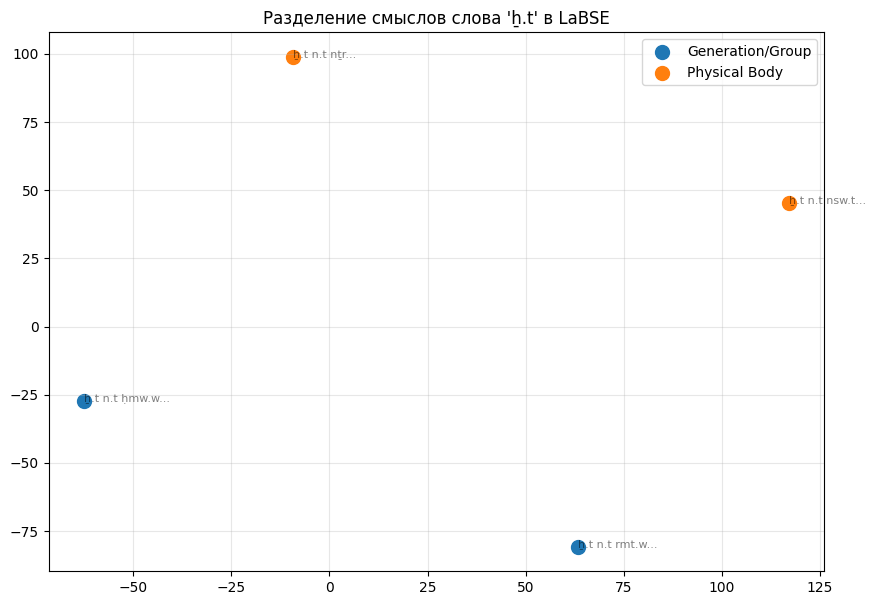

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def plot_word_senses(model, tokenizer, sentences, target_word, labels):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    vectors = []
    
    for sent in sentences:
        inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            output = model(**inputs)
        
        
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        idx = [i for i, t in enumerate(tokens) if target_word in t.replace('##', '')]
        
        if idx:

            vec = output.last_hidden_state[0, idx].mean(dim=0).cpu().numpy()
            vectors.append(vec)
    
    vectors = np.array(vectors)
    

    tsne = TSNE(n_components=2, perplexity=min(5, len(vectors)-1), random_state=42)
    embeds_2d = tsne.fit_transform(vectors)
    

    plt.figure(figsize=(10, 7))
    for i, label in enumerate(set(labels)):
        mask = np.array(labels) == label
        plt.scatter(embeds_2d[mask, 0], embeds_2d[mask, 1], label=label, s=100)
    
    for i, txt in enumerate(sentences):
        plt.annotate(txt[:30] + "...", (embeds_2d[i, 0], embeds_2d[i, 1]), alpha=0.5, fontsize=8)
        
    plt.title(f"Разделение смыслов слова '{target_word}' в LaBSE")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


test_sents = [
    "ẖ.t n.t nṯr", "ẖ.t n.t nsw.t",  
    "ẖ.t n.t rmt.w", "ẖ.t n.t ḥmw.w" 
]
test_labels = ["Physical Body", "Physical Body", "Generation/Group", "Generation/Group"]

plot_word_senses(model, tokenizer, test_sents, "ẖ.t", test_labels)

In [33]:
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
from collections import defaultdict

model = AutoModel.from_pretrained('./LaBSE_egyptian_finetuned')
tokenizer = AutoTokenizer.from_pretrained('./LaBSE_egyptian_finetuned')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

def get_word_embedding_in_context(sentence, target_word, model, tokenizer, device):
    """
    Получить контекстный эмбеддинг целевого слова в предложении
    
    Args:
        sentence: "jri =f pr m nswt"
        target_word: "pr"
    
    Returns:
        embedding: [768] вектор контекстного эмбеддинга слова
    """

    tokens = tokenizer.tokenize(sentence)
    

    target_positions = []
    for i, token in enumerate(tokens):

        clean_token = token.replace('##', '')
        if target_word in clean_token or clean_token in target_word:
            target_positions.append(i)
    
    
    encoded = tokenizer(
        sentence,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    )
    
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = outputs[0]  
    

    word_embeddings = []
    for pos in target_positions:
        actual_pos = pos + 1
        if actual_pos < token_embeddings.size(1):
            word_embeddings.append(token_embeddings[0, actual_pos, :])
    
    if len(word_embeddings) == 0:
        return None
    
    word_embedding = torch.stack(word_embeddings).mean(dim=0)
    

    word_embedding = F.normalize(word_embedding, p=2, dim=0)
    
    return word_embedding.cpu().numpy()


test_sentence = "jri =f pr m nswt"
test_word = "pr"

embedding = get_word_embedding_in_context(test_sentence, test_word, model, tokenizer, device)
print(f"✓ Эмбеддинг слова '{test_word}' в контексте '{test_sentence}':")
print(f"  Shape: {embedding.shape}")
print(f"  Norm: {np.linalg.norm(embedding):.4f}")

The tokenizer you are loading from './LaBSE_egyptian_finetuned' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Эмбеддинг слова 'pr' в контексте 'jri =f pr m nswt':
  Shape: (768,)
  Norm: 1.0000


In [14]:
import ast
import pandas as pd

def safe_literal_eval(val):
    """Безопасное преобразование строки в список"""
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return ast.literal_eval(val)
    except:
        return []

def collect_word_contexts(df, target_words):
    """
    Собрать все контексты для списка целевых слов
    
    Args:
        df: датафрейм с колонками ['lemmatized_sentence', 'lemmas_list', 'lemma_ids_list']
        target_words: ['sDm', 'jri', 'nTr', ...]
    
    Returns:
        contexts: {
            'sDm': [
                {'sentence': 'sDm =f ...', 'lemma_id': 150740, 'index': 0},
                {'sentence': 'jw =j sDm ...', 'lemma_id': 150740, 'index': 1},
                ...
            ],
            'jri': [...],
            ...
        }
    """
    contexts = {word: [] for word in target_words}
    
    for idx, row in df.iterrows():
        sentence = row['lemmatized_sentence']
        
        
        lemmas = safe_literal_eval(row['lemmas_list'])  
        lemma_ids = safe_literal_eval(row['lemma_ids_list'])  
        
        
        for i, lemma in enumerate(lemmas):
            
            clean_lemma = lemma.split('=')[0].split('.')[0].split(',')[0]
            
            if clean_lemma in target_words:
                contexts[clean_lemma].append({
                    'sentence': sentence,
                    'lemma': lemma,  
                    'lemma_id': lemma_ids[i] if i < len(lemma_ids) else None,
                    'position': i,
                    'df_index': idx
                })
    

    print("=== СОБРАННЫЕ КОНТЕКСТЫ ===")
    for word, ctxs in contexts.items():
        if len(ctxs) > 0:
            unique_ids = set(c['lemma_id'] for c in ctxs if c['lemma_id'])
            print(f"{word:10s}: {len(ctxs):5d} контекстов, {len(unique_ids)} уникальных lemma_id")
        else:
            print(f"{word:10s}: {len(ctxs):5d} контекстов")
    
    return contexts


target_words = ['sḏm']


df_full = pd.read_csv('train_pairs.csv')  


df_full['lemmas_list'] = df_full['lemmas_list'].apply(safe_literal_eval)
df_full['lemma_ids_list'] = df_full['lemma_ids_list'].apply(safe_literal_eval)

contexts = collect_word_contexts(df_full, target_words)


if contexts[target_words[0]]:
    print("\n=== ПРИМЕРЫ КОНТЕКСТОВ ===")
    word = target_words[0]
    for i, ctx in enumerate(contexts[word][:5]):
        print(f"\n{i+1}. Lemma ID: {ctx['lemma_id']}")
        print(f"   Sentence: {ctx['sentence']}")
        print(f"   Position: {ctx['position']}")
else:
    print(f"\nНе найдено контекстов для слова: {target_words[0]}")

/tmp/ipykernel_132/391519825.py:73: DtypeWarning: Columns (31,40,53,55,56,57,59,60,63,64,65,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('train_pairs.csv')  # с колонкой lemma_ids_list


=== СОБРАННЫЕ КОНТЕКСТЫ ===
sḏm       :   133 контекстов, 2 уникальных lemma_id

=== ПРИМЕРЫ КОНТЕКСТОВ ===

1. Lemma ID: 150560
   Sentence: n =f r bw n.tj zꜣ =k jm ḥr sḏm n mdw
   Position: 9

2. Lemma ID: 150560
   Sentence: jn wršu̯ =k sḏr =k ḥr mḥ m jri̯ mri̯ ḥzi̯ wḏ nb =k jw ḥm =f r jri̯ sꜣr =k ꜥšꜣ jqr r ꜣḫ.w n.j zꜣ n.j zꜣ =k n-ḏ,t r ḏd rmṯ nb sḏm =sn jri̯ n =k ḥm =j
   Position: 35

3. Lemma ID: 150560
   Sentence: jn rrj rḏi̯ Mrrj nb =j nḏm jr =f nb.t bꜣk.t n.jt pr-ḏ.t m sḏm mdw r bꜣk pn sn
   Position: 14

4. Lemma ID: 150560
   Sentence: n.tj sḏm =f n =k
   Position: 1

5. Lemma ID: 150560
   Sentence: jr rmṯ nb jri̯ =sn jḫ.t nb ḏw r jz =j pn n.j ẖr-nṯr wdi̯ =f jnr m =f ḥr mw.t =f jw sḏm =j ḥnꜥ =f m ḏꜣḏꜣ.t tf šps.j jqr n.j nṯr-ꜥꜣ nb jmn.t
   Position: 23


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def plot_word_contexts(model, tokenizer, word_contexts, target_word):
    """
    Визуализация контекстных векторов на основе собранного словаря contexts
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    vectors = []
    labels = []
    sentences = []
    
    print(f"Обработка контекстов для слова: {target_word}...")
    
    for ctx in word_contexts:
        sent = ctx['sentence']
        lemma_id = ctx['lemma_id']
        
        inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            output = model(**inputs)

        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        
        target = ctx['lemma'].split('=')[0] 
        idx = [i for i, t in enumerate(tokens) if target in t.replace('##', '')]
        
        if idx:
            vec = output.last_hidden_state[0, idx].mean(dim=0).cpu().numpy()
            vectors.append(vec)
            labels.append(f"ID: {lemma_id}") # Метка для легенды
            sentences.append(sent)


    vectors = np.array(vectors)
    

    perp = min(30, len(vectors) - 1) if len(vectors) > 1 else 1
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, init='pca', learning_rate='auto')
    embeds_2d = tsne.fit_transform(vectors)
    

    plt.figure(figsize=(12, 8))
    
    unique_labels = sorted(list(set(labels)))
    colors = plt.cm.get_cmap('viridis', len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        mask = [l == label for l in labels]
        plt.scatter(embeds_2d[np.array(mask), 0], 
                    embeds_2d[np.array(mask), 1], 
                    label=label, 
                    alpha=0.7, 
                    s=60)
    
    for i in np.random.choice(range(len(sentences)), min(10, len(sentences)), replace=False):
        plt.annotate(sentences[i][:40] + "...", 
                     (embeds_2d[i, 0], embeds_2d[i, 1]), 
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=8, alpha=0.6)
        
    plt.title(f"Семантическое пространство контекстов '{target_word}' (LaBSE Fine-tuned)")
    plt.legend(title="Lemma ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

Обработка контекстов для слова: sḏm...


/tmp/ipykernel_107/64206663.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


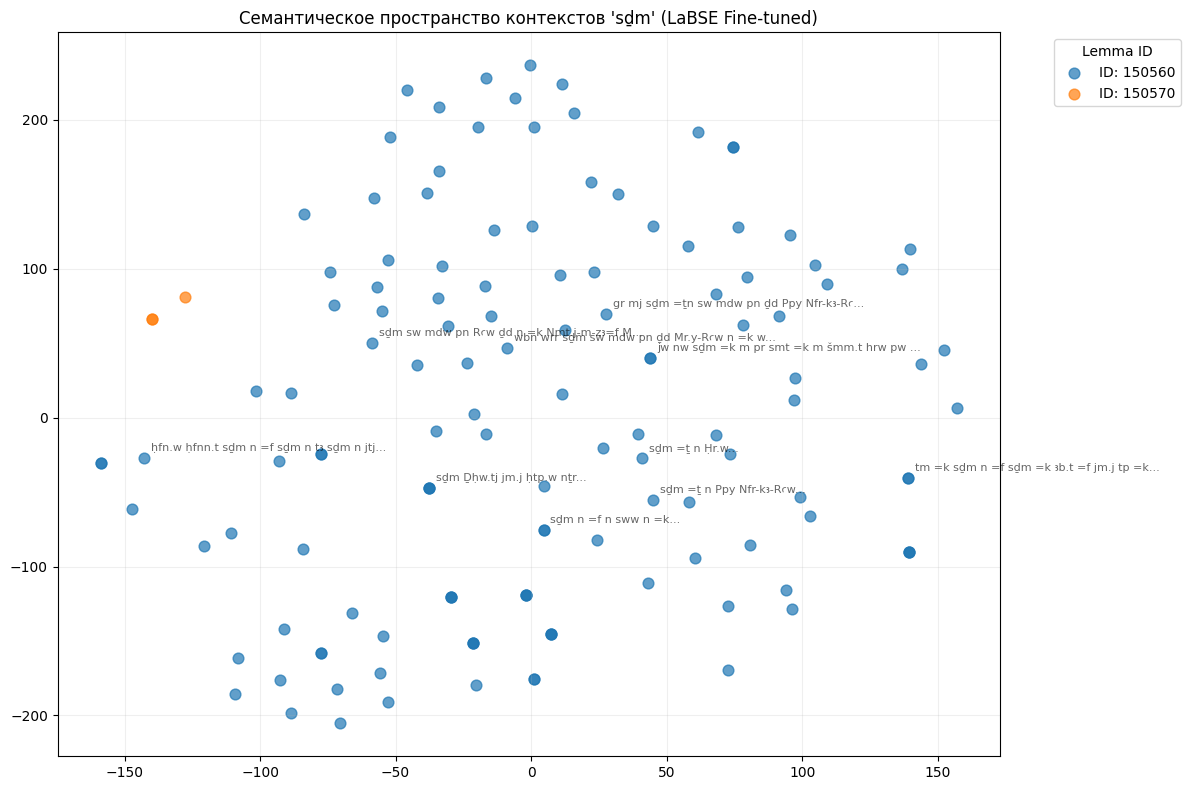

In [55]:
plot_word_contexts(model, tokenizer, contexts['sḏm'], 'sḏm')

In [10]:
def collect_word_contexts(df, target_words):
    """
    Собрать все контексты для списка целевых слов
    
    Args:
        df: датафрейм с колонками ['lemmatized_sentence', 'lemmas_list', 'lemma_ids_list']
        target_words: ['sDm', 'jri', 'nTr', ...]
    
    Returns:
        contexts: {
            'sDm': [
                {'sentence': 'sDm =f ...', 'lemma_id': 150740, 'index': 0},
                {'sentence': 'jw =j sDm ...', 'lemma_id': 150740, 'index': 1},
                ...
            ],
            'jri': [...],
            ...
        }
    """
    contexts = {word: [] for word in target_words}
    
    for idx, row in df.iterrows():
        sentence = row['lemmatized_sentence']
        
   
        lemmas = safe_literal_eval(row['lemmas_list'])  
        lemma_ids = safe_literal_eval(row['lemma_ids_list']) 
        

        for i, lemma in enumerate(lemmas):
      
            clean_lemma = lemma.split('=')[0].split('.')[0].split(',')[0]
            
            if clean_lemma in target_words:
                contexts[clean_lemma].append({
                    'sentence': sentence,
                    'lemma': lemma, 
                    'lemma_id': lemma_ids[i] if i < len(lemma_ids) else None,
                    'position': i,
                    'df_index': idx
                })
    

    print("=== СОБРАННЫЕ КОНТЕКСТЫ ===")
    for word, ctxs in contexts.items():
        if len(ctxs) > 0:
            unique_ids = set(c['lemma_id'] for c in ctxs if c['lemma_id'])
            print(f"{word:10s}: {len(ctxs):5d} контекстов, {len(unique_ids)} уникальных lemma_id")
        else:
            print(f"{word:10s}: {len(ctxs):5d} контекстов")
    
    return contexts

In [49]:

df_full = pd.read_csv('train_pairs.csv') 

df_full['lemmas_list'] = df_full['lemmas_list'].apply(safe_literal_eval)
df_full['lemma_ids_list'] = df_full['lemma_ids_list'].apply(safe_literal_eval)


/tmp/ipykernel_132/1467657855.py:1: DtypeWarning: Columns (31,40,53,55,56,57,59,60,63,64,65,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('train_pairs.csv')


In [50]:
target_words = ['sḏm', 'ꜥnḫ', 'jri̯', 'nṯr', 'nswt', 'mri̯', 'mw', 'pr']

In [51]:
contexts = collect_word_contexts(df_full, target_words)

=== СОБРАННЫЕ КОНТЕКСТЫ ===
sḏm       :   133 контекстов, 2 уникальных lemma_id
ꜥnḫ       :   742 контекстов, 11 уникальных lemma_id
jri̯      :   945 контекстов, 5 уникальных lemma_id
nṯr       :  1535 контекстов, 11 уникальных lemma_id
nswt      :   810 контекстов, 1 уникальных lemma_id
mri̯      :   266 контекстов, 2 уникальных lemma_id
mw        :   503 контекстов, 6 уникальных lemma_id
pr        :   729 контекстов, 11 уникальных lemma_id


In [52]:
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
import torch

def calculate_labse_metrics(model, tokenizer, word_contexts, target_word):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    vectors = []
    true_labels = []
    
    for ctx in word_contexts:
        inputs = tokenizer(ctx['sentence'], return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            output = model(**inputs)
        
        # Находим индекс токена нашего слова
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        target = ctx['lemma'].split('=')[0]
        idx = [i for i, t in enumerate(tokens) if target in t.replace('##', '')]
        
        if idx:
            # Берём вектор из последнего скрытого слоя (Mean Pooling по токенам слова)
            vec = output.last_hidden_state[0, idx].mean(dim=0).cpu().numpy()
            vectors.append(vec)
            true_labels.append(str(ctx['lemma_id']))
            
    if len(set(true_labels)) < 2 or len(vectors) < 10:
        return None

    X = np.array(vectors)
    n_clusters = len(set(true_labels))
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    predicted_labels = kmeans.fit_predict(X)
    
    ari = adjusted_rand_score(true_labels, predicted_labels)
    sil = silhouette_score(X, true_labels)
    
    return {"ARI": ari, "Silhouette": sil, "Count": len(X)}

# Собираем данные для LaBSE
print(f"{'Word':10s} | {'Count':6s} | {'ARI':8s} | {'Silhouette':10s}")
print("-" * 45)

for word in target_words:
    if word in contexts and len(contexts[word]) > 0:
        res = calculate_labse_metrics(model, tokenizer, contexts[word], word)
        if res:
            print(f"{word:10s} | {res['Count']:6d} | {res['ARI']:.4f} | {res['Silhouette']:.4f}")

Word       | Count  | ARI      | Silhouette
---------------------------------------------
sḏm        |    133 | -0.0197 | 0.0635
ꜥnḫ        |    732 | 0.0116 | -0.0625
jri̯       |    945 | 0.0038 | -0.0506
nṯr        |   1527 | 0.0585 | -0.0321
mri̯       |    266 | -0.0008 | 0.0284
mw         |    501 | 0.5351 | 0.1556
pr         |    727 | 0.1554 | 0.0987


In [53]:
def calculate_labse_metrics_advanced(model, tokenizer, word_contexts, target_word):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    vectors = []
    true_labels = []
    
    for ctx in word_contexts:
        # Добавляем output_hidden_states=True, чтобы иметь доступ ко всем слоям
        inputs = tokenizer(ctx['sentence'], return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            output = model(**inputs, output_hidden_states=True)
        
        # Берем предпоследний слой (index -2)
        # Он часто чище с точки зрения семантики слова
        target_layer = output.hidden_states[-2] 
        
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        target = ctx['lemma'].split('=')[0]
        
        # Более точный поиск индекса
        idx = [i for i, t in enumerate(tokens) if target in t.replace('##', '') 
               and t not in tokenizer.all_special_tokens]
        
        if idx:
            # Извлекаем контекстуализированные векторы для токенов слова
            vec = target_layer[0, idx].mean(dim=0).cpu().numpy()
            vectors.append(vec)
            true_labels.append(str(ctx['lemma_id']))
            
    if len(set(true_labels)) < 2 or len(vectors) < 10:
        return None

    X = np.array(vectors)
    n_clusters = len(set(true_labels))
    
    # Рекомендую попробовать косинусное расстояние, так как в BERT оно важнее евклидова
    # Но для чистоты эксперимента оставим KMeans (он использует евклидово)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    predicted_labels = kmeans.fit_predict(X)
    
    ari = adjusted_rand_score(true_labels, predicted_labels)
    sil = silhouette_score(X, true_labels)
    
    return {"ARI": ari, "Silhouette": sil, "Count": len(X)}

In [54]:
print(f"{'Word':10s} | {'Count':6s} | {'ARI':8s} | {'Silhouette':10s}")
print("-" * 45)

for word in target_words:
    if word in contexts and len(contexts[word]) > 0:
        res = calculate_labse_metrics_advanced(model, tokenizer, contexts[word], word)
        if res:
            print(f"{word:10s} | {res['Count']:6d} | {res['ARI']:.4f} | {res['Silhouette']:.4f}")

Word       | Count  | ARI      | Silhouette
---------------------------------------------
sḏm        |    133 | 0.0264 | 0.0924
ꜥnḫ        |    732 | -0.0166 | -0.1128
jri̯       |    945 | 0.0005 | -0.0850
nṯr        |   1527 | 0.0711 | -0.0105
mri̯       |    266 | -0.0002 | 0.0435
mw         |    501 | 0.5414 | 0.2120
pr         |    727 | 0.1973 | 0.2242


In [ ]:
Word       | Count  | ARI      | Silhouette
---------------------------------------------
sḏm        |    133 | -0.0226 | 0.0524
ꜥnḫ        |    736 | 0.0240 | -0.1646
jri̯       |    942 | 0.0011 | -0.1526
nṯr        |   1527 | 0.0390 | -0.1726
mri̯       |    266 | 0.0182 | 0.1484
mw         |    506 | 0.0746 | -0.1063
pr         |    712 | 0.1244 | -0.0509

In [55]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

def evaluate_retrieval_performance(model, tokenizer, test_df, device, num_negatives=99):
    """
    Замеряет, насколько хорошо модель находит правильный перевод среди дистракторов.
    """
    model.eval()
    model.to(device)
    
    ranks = []
    hits_at_1 = 0
    hits_at_5 = 0

    print(f"Кодирование {len(test_df)} немецких предложений...")
    all_german_texts = test_df['german'].tolist()
    
    with torch.no_grad():

        batch_size = 32
        all_deu_embs = []
        for i in range(0, len(all_german_texts), batch_size):
            batch_texts = all_german_texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
            out = model(**encoded)
            embs = mean_pooling(out, encoded['attention_mask'])
            all_deu_embs.append(F.normalize(embs, p=2, dim=1))
        
        all_deu_embs = torch.cat(all_deu_embs, dim=0) 


    print("Запуск оценки Retrieval...")

    for idx, (df_idx, row) in enumerate(tqdm(test_df.iterrows(), total=len(test_df))):
        egy_text = row['egyptian']
        

        egy_encoded = tokenizer(egy_text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            egy_out = model(**egy_encoded)
            egy_emb = mean_pooling(egy_out, egy_encoded['attention_mask'])
            egy_emb = F.normalize(egy_emb, p=2, dim=1) 
        

        similarities = torch.matmul(egy_emb, all_deu_embs.T).squeeze(0) 
        
   
        sorted_indices = torch.argsort(similarities, descending=True)
        

        found_tensor = (sorted_indices == idx).nonzero(as_tuple=True)[0]
        
        if len(found_tensor) > 0:
            rank = found_tensor.item() + 1
            ranks.append(rank)
            if rank == 1: hits_at_1 += 1
            if rank <= 5: hits_at_5 += 1


    total = len(test_df)
    mrr = np.mean([1.0/r for r in ranks])
    r1 = hits_at_1 / total
    r5 = hits_at_5 / total

    print("\n" + "="*30)
    print("FINAL RETRIEVAL METRICS")
    print("="*30)
    print(f"Recall@1: {r1:.4f}  ")
    print(f"Recall@5: {r5:.4f}  ")
    print(f"MRR:      {mrr:.4f} ")
    print("="*30)
    
    return {"R1": r1, "R5": r5, "MRR": mrr}

metrics = evaluate_retrieval_performance(model, tokenizer, test_df, device)

Кодирование 2340 немецких предложений...
Запуск оценки Retrieval...


100%|██████████| 2340/2340 [00:08<00:00, 290.61it/s]


FINAL RETRIEVAL METRICS
Recall@1: 0.7132  
Recall@5: 0.9026  
MRR:      0.7965 


In [37]:
from sklearn.model_selection import train_test_split
df_final = pd.read_csv('parallel_corpus_ready.csv')

train_val_df, test_df = train_test_split(df_final, test_size=0.1, random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.111, random_state=42) 

In [40]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def plot_word_contexts(model, tokenizer, word_contexts, target_word, translation_df):
    """
    Визуализация контекстных векторов на основе собранного словаря contexts
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    id_to_trans = dict(zip(translation_df['lemma_id'].astype(str), 
                           translation_df['translation_en']))
    
    vectors = []
    labels = []
    sentences = []
    
    print(f"Обработка контекстов для слова: {target_word}...")
    
    for ctx in word_contexts:
        sent = ctx['sentence']
        lemma_id = ctx['lemma_id']
        
        translation = id_to_trans.get(lemma_id, "Unknown")
        label_text = f"ID {lemma_id}: {translation}"
        
        
        inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            output = model(**inputs, output_hidden_states=True)
        
        
        target_layer = output.hidden_states[-2]
        
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        target = ctx['lemma'].split('=')[0]
        
        
        idx = [i for i, t in enumerate(tokens) if target in t.replace('##', '') 
               and t not in tokenizer.all_special_tokens]
        
        if idx:
            # 3. Берем вектор из нужного слоя
            vec = target_layer[0, idx].mean(dim=0).cpu().numpy()
            vectors.append(vec)
            labels.append(label_text) 
            sentences.append(sent)
    


    vectors = np.array(vectors)
    
    
    perp = min(30, len(vectors) - 1) if len(vectors) > 1 else 1
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, init='pca', learning_rate='auto')
    embeds_2d = tsne.fit_transform(vectors)
    
    
    plt.figure(figsize=(12, 8))
    
    unique_labels = sorted(list(set(labels)))
    colors = plt.cm.get_cmap('viridis', len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        mask = [l == label for l in labels]
        plt.scatter(embeds_2d[np.array(mask), 0], 
                    embeds_2d[np.array(mask), 1], 
                    label=label, 
                    alpha=0.7, 
                    s=60)
    

    for i in np.random.choice(range(len(sentences)), min(10, len(sentences)), replace=False):
        plt.annotate(sentences[i][:40] + "...", 
                     (embeds_2d[i, 0], embeds_2d[i, 1]), 
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=8, alpha=0.6)
        
    plt.title(f"Семантическое пространство контекстов '{target_word}' (LaBSE Fine-tuned)")
    plt.legend(title="Lemma ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()

In [23]:
translation_df = pd.read_parquet('translation_df.parquet')

In [24]:
translation_df

,lemma_id,name,pos,wclassnum,woart,translation_en,graphics
0,1,ꜣ,XX,1010,3,vulture; bird (gen.),G1
1,10,ꜣj.wj,WS,1010,1003,pair of bandages (med.),G1 M17 G43 Z4 V1 V1
2,100,Ꜣbḏ,WS,10020,1001,Fisher,
3,100000,ḥw.t-šn.wt,WS,10045,1102,Mansion-of-? (sanctuary of Nut at Heliopolis),O7 V7 M17 X1 V1
4,100010,ḥw.t-kꜣ,WS,1000,1102,ka-house (tomb chapel); chapel (for a statue i...,O6 X1 D28
...,...,...,...,...,...,...,...
38776,853664,None,None,None,None,the two divine eyes,None
38777,851809,None,None,None,None,"to do, make",None
38778,851810,None,None,None,None,[connected to a specific object (general)],None
38779,852348,None,None,None,None,to cause that,None


In [41]:
from matplotlib.backends.backend_pdf import PdfPages


pdf_filename = 'labse_semantic_analysis_2.pdf'

with PdfPages(pdf_filename) as pdf:
    for word in target_words:
        if word in contexts:
            plot_word_contexts(model, tokenizer, contexts[word], word, translation_df)
            
            pdf.savefig()  
            
            plt.close()

print(f"Все графики успешно сохранены в файл: {pdf_filename}")

Обработка контекстов для слова: sḏm...


/tmp/ipykernel_132/2253761763.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


Обработка контекстов для слова: ꜥnḫ...


/tmp/ipykernel_132/2253761763.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


Обработка контекстов для слова: jri̯...


/tmp/ipykernel_132/2253761763.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


Обработка контекстов для слова: nṯr...


/tmp/ipykernel_132/2253761763.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


Обработка контекстов для слова: nswt...


/tmp/ipykernel_132/2253761763.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


Обработка контекстов для слова: mri̯...


/tmp/ipykernel_132/2253761763.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


Обработка контекстов для слова: mw...


/tmp/ipykernel_132/2253761763.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


Обработка контекстов для слова: pr...


/tmp/ipykernel_132/2253761763.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


Все графики успешно сохранены в файл: labse_semantic_analysis_2.pdf
